In [ ]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [ ]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('xhlulu/140k-real-and-fake-faces', path="/content/", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Activation, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import cv2

In [ ]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# Set up directories and parameters
img_dir = '/content/real_vs_fake/real-vs-fake/'
BATCH_SIZE = 64
IMAGE_SIZE = 128
input_shape = (128, 128, 1)

In [ ]:
# Data generators
data_gen = ImageDataGenerator()

train_generator = data_gen.flow_from_directory(
    img_dir + 'train/',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)

valid_generator = data_gen.flow_from_directory(
    img_dir + 'valid/',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)

test_generator = data_gen.flow_from_directory(
    img_dir + 'test/',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,
    color_mode='grayscale',
    shuffle=False,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


Sample training images:


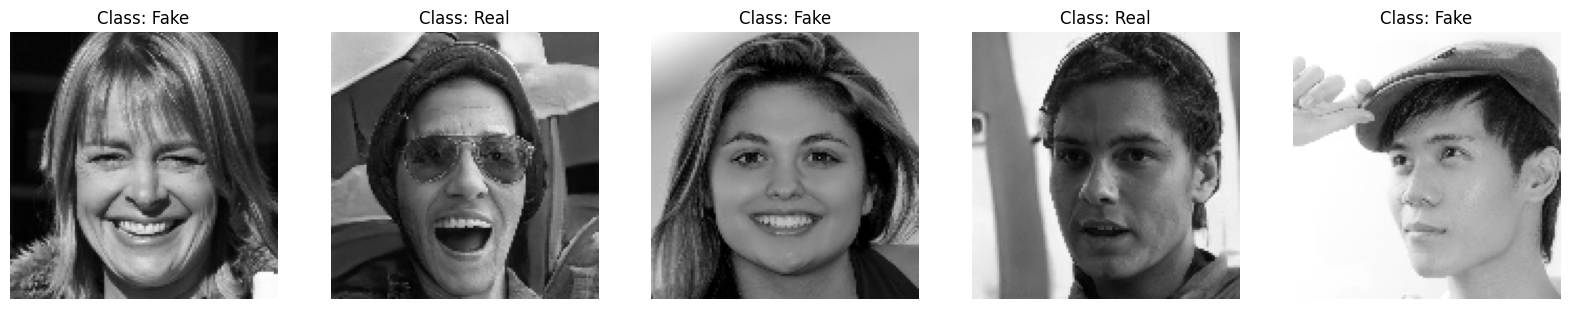

In [ ]:
# EDA: Display sample images
def plot_samples(generator, n=5):
    fig, axes = plt.subplots(1, n, figsize=(20, 4))
    for i, (img, label) in enumerate(generator):
        if i >= n:
            break
        axes[i].imshow(img[0].squeeze(), cmap='gray')
        axes[i].set_title(f"Class: {'Real' if label[0] == 0 else 'Fake'}")
        axes[i].axis('off')
    plt.show()

print("Sample training images:")
plot_samples(train_generator)

In [ ]:
# Model definition
def block(y, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(y)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def create_model():
    inp = Input((IMAGE_SIZE, IMAGE_SIZE, 1))
    x = Conv2D(4, 3, padding='same')(inp)
    x = MaxPool2D(2)(x)
    x = block(x, 16, 3)
    x = block(x, 32, 3)
    x = block(x, 64, 3)
    x = block(x, 128, 3)
    x = block(x, 64, 3)
    x = block(x, 32, 3)
    x = GlobalAveragePooling2D()(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs=[inp], outputs=[out])

model = create_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 4)         │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 191,257 (747.10 KB)

 Trainable params: 190,585 (744.47 KB)

 Non-trainable params: 672 (2.62 KB)

In [ ]:
# Callbacks
checkpoint_path = "best_model_weights.weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
# Training
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[checkpoint_callback, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1556/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7175 - loss: 0.5399
Epoch 1: val_accuracy improved from -inf to 0.84980, saving model to best_model_weights.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 87ms/step - accuracy: 0.7178 - loss: 0.5394 - val_accuracy: 0.8498 - val_loss: 0.3447 - learning_rate: 0.0010
Epoch 2/10
1556/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8896 - loss: 0.2627
Epoch 2: val_accuracy did not improve from 0.84980
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 0.8897 - loss: 0.2626 - val_accuracy: 0.6234 - val_loss: 1.1607 - learning_rate: 0.0010
Epoch 3/10
1556/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9340 - loss: 0.1694
Epoch 3: val_accuracy improved from 0.84980 to 0.90285, saving model to best_model_weights.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 80ms/step - accuracy: 0.9340 - loss: 0.1694 - val_accuracy: 0.9028 - val_loss: 0.2504 - learning_rate: 0.0010
Epoch 4/10
1556/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

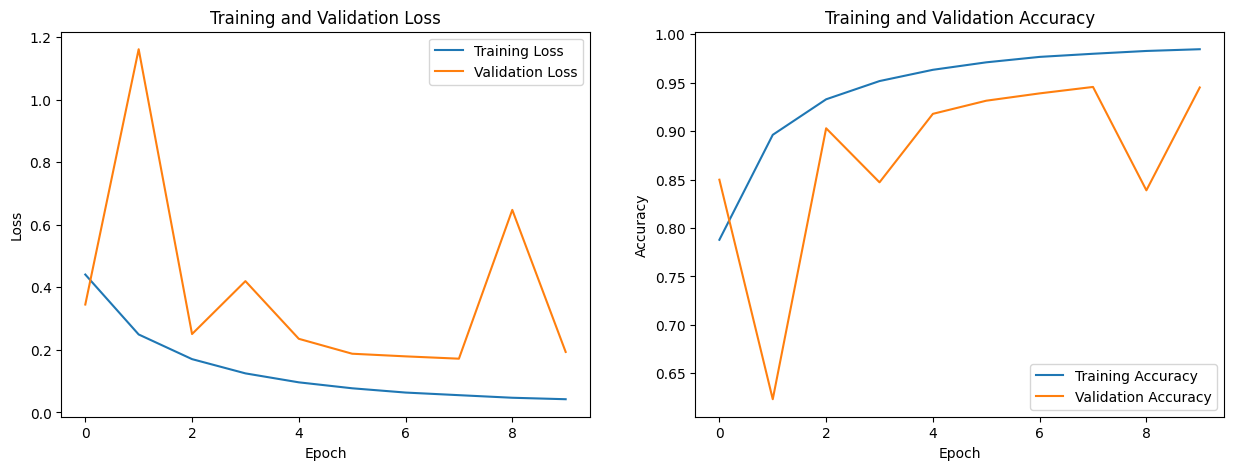

In [ ]:
# Plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

plot_history(history)

In [ ]:
# After training, load the best weights
model.load_weights(checkpoint_path)

In [ ]:
# Evaluation
y_pred = model.predict(test_generator, verbose=1)
y_test = test_generator.classes

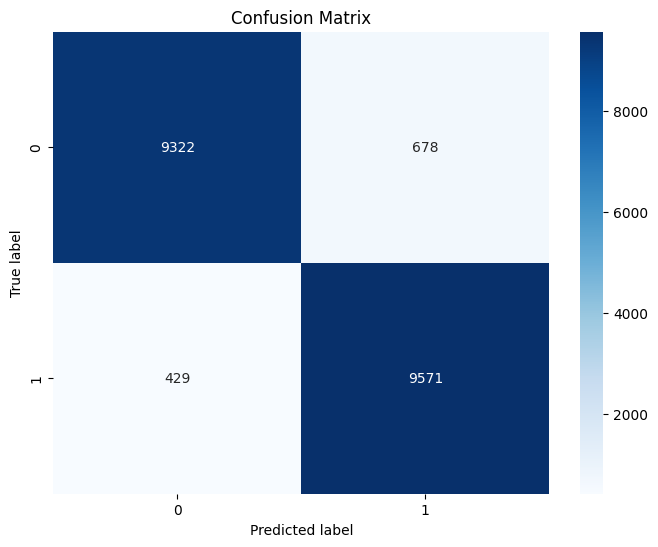

In [ ]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred.round())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

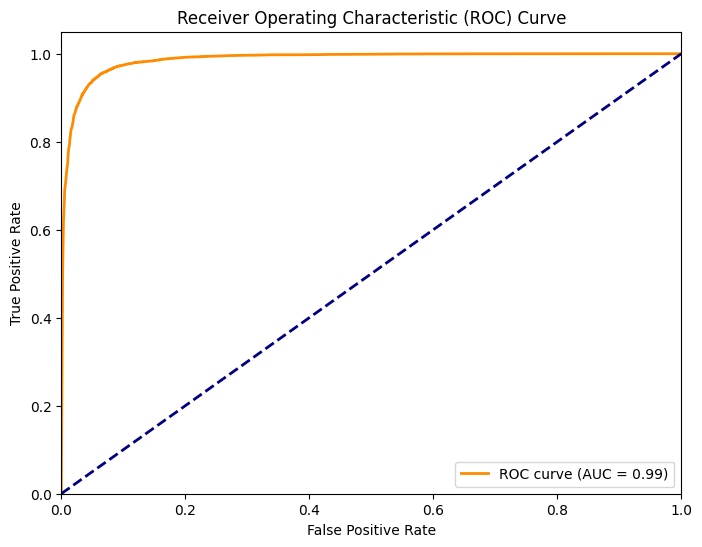

In [ ]:
# ROC Curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_test, y_pred)

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     10000
           1       0.93      0.96      0.95     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [ ]:
# Save the model
model.save('/content/drive/MyDrive/ML/Deep-fake-detection/deepfake_detection.keras')

print("Model saved as 'deepfake_detection.keras'")

Model saved as 'deepfake_detection.keras'
